In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

In [4]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [5]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False)
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...
latent step: 9375


## 転写先

In [11]:
img_dir = 'imgs_align'
for i,file in enumerate(os.listdir(img_dir)):
    print(f'{i:2}: {file}')

 0: azuki_default.png
 1: ceo_default.png
 2: check1.png
 3: check2.png
 4: danda_default.png
 5: detective.png
 6: detective_02.png
 7: idPhoto.png
 8: mio_happy.png
 9: mio_shock.png
10: mio_silence.png
11: mio_u.png
12: nanko_default.png
13: ookawa_angry.png
14: ookawa_angry2.png
15: ookawa_default.png
16: ookawa_high.png
17: ookawa_regret.png
18: ookawa_smile.png
19: ookawa_surprised.png
20: pharmacist.png
21: saki.png
22: saki_glasses.png
23: sandy.png
24: takebe_default.png
25: test01.png
26: test01_02.png
27: test01_03.png
28: test01_04.png
29: test02.png
30: woman_default.png
31: yotaka_bald.png
32: yotaka_bushy.png
33: yotaka_default.png
34: yotaka_smile.png
35: yotaka_smile2.png


In [177]:
data_to = ImageDataset(img_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
ind_batch_to = [0,4,12,15,24,27]
batch_to = np.array(data_to[ind_batch_to[0]]['img'][None])
names_batch_to = [os.path.splitext(str(data_to.paths[ind_batch_to[0]]))[0]]
for i in range(1, len(ind_batch_to)):
    batch_to = np.append(batch_to, data_to[ind_batch_to[i]]['img'][None], axis=0)
    names_batch_to.append(os.path.splitext(str(data_to.paths[ind_batch_to[i]]))[0])
batch_to = torch.tensor(batch_to)

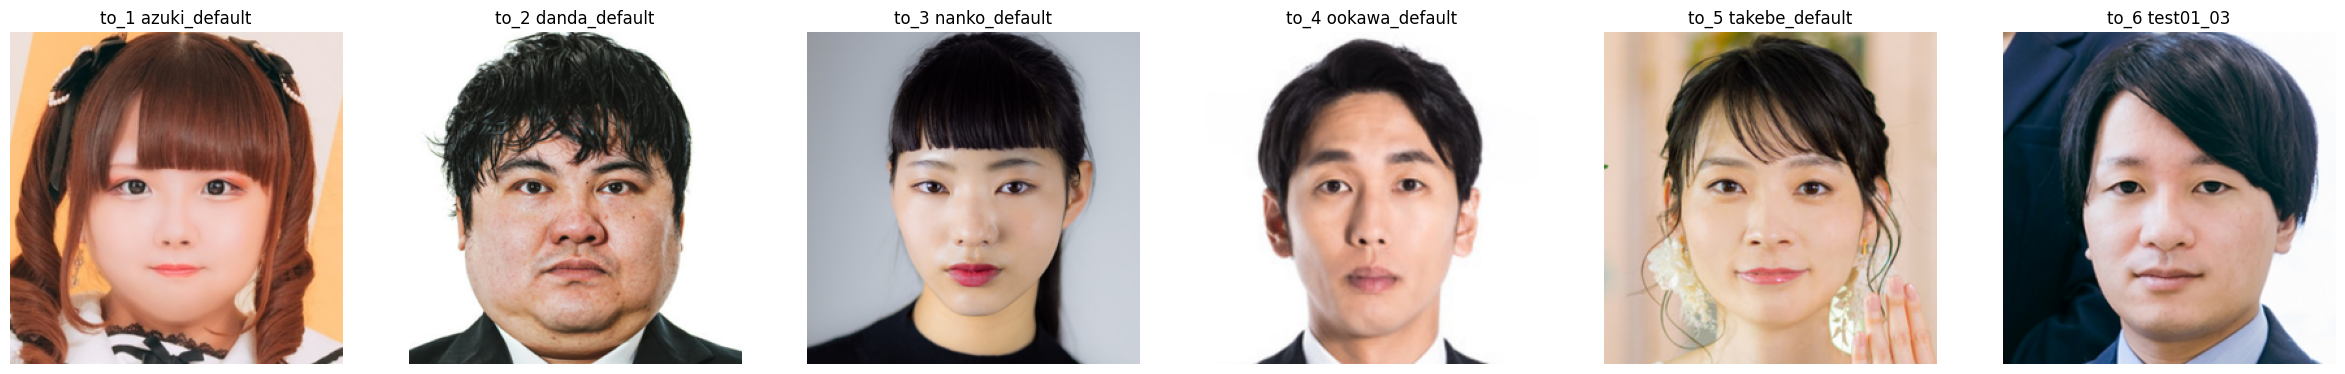

In [178]:
import matplotlib.pyplot as plt

num_to = len(batch_to)
fig, ax = plt.subplots(1, num_to, figsize=(5*num_to, 5))
for i in range(num_to):
    ax[i].imshow(batch_to[i].permute([1, 2, 0]) / 2 + 0.5)
    ax[i].set_title(f"to_{i+1} {names_batch_to[i]}")
    ax[i].axis('off')

In [179]:
cond_to = model.encode(batch_to.to(device))
cond_to_norm = cls_model.normalize(cond_to)
xT = model.encode_stochastic(batch_to.to(device), cond_to, T=250)

## Pose

In [183]:
img_pose_dir = 'imgs_test/imgs_prepare/pose'
for i,file in enumerate(os.listdir(img_pose_dir)):
    print(f'{i:2}: {file}')

 0: mio_silence2mio_happy-no00.png
 1: mio_silence2mio_happy-no01.png
 2: mio_silence2mio_u-no00.png
 3: mio_silence2mio_u-no01.png
 4: ookawa_default2ookawa_angry2-no00.png
 5: ookawa_default2ookawa_angry2-no01.png
 6: yotaka_default2yotaka_smile-no00.png
 7: yotaka_default2yotaka_smile-no01.png
 8: yotaka_default2yotaka_smile2-no00.png
 9: yotaka_default2yotaka_smile2-no01.png


In [184]:
data_pose_from = ImageDataset(img_pose_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
ind_batch_pose_from = [2,3]
batch_pose_from = np.array(data_pose_from[ind_batch_pose_from[0]]['img'][None])
names_batch_pose_from = [os.path.splitext(str(data_pose_from.paths[ind_batch_pose_from[0]]))[0]]
for i in range(1, len(ind_batch_pose_from)):
    batch_pose_from = np.append(batch_pose_from, data_pose_from[ind_batch_pose_from[i]]['img'][None], axis=0)
    names_batch_pose_from.append(os.path.splitext(str(data_pose_from.paths[ind_batch_pose_from[i]]))[0])
batch_pose_from = torch.tensor(batch_pose_from)

In [185]:
cond_pose_from = model.encode(batch_pose_from.to(device))
cond_pose_change = cls_model.normalize(cond_pose_from[1][None]) - cls_model.normalize(cond_pose_from[0][None])

In [186]:
preds_pose = []
alpha = torch.tensor(np.linspace(0, 1.2, 7, dtype=np.float32)).to(device)
for i, alp in enumerate(alpha):
    cond2 = cond_to_norm + alp * cond_pose_change
    cond2 = cls_model.denormalize(cond2)
    pred = model.render(xT, cond2, T=100)
    preds_pose.append(pred)

In [187]:
preds_pose = torch.stack(preds_pose)
preds_pose = preds_pose.permute(1,0,2,3,4)

In [188]:
from PIL import Image

preds_pose_pil = []
for pred in preds_pose:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_pose_pil.append(pred_pil)

## Eye

In [189]:
img_eye_dir = 'imgs_test/imgs_prepare/eye'
for i,file in enumerate(os.listdir(img_eye_dir)):
    print(f'{i:2}: {file}')

 0: mio_silence.png
 1: mio_silence2mio_happy-eye.png
 2: mio_silence2mio_u-eye.png
 3: ookawa_default.png
 4: ookawa_default2ookawa_angry2-eye.png
 5: yotaka_default.png
 6: yotaka_default2yotaka_smile-eye.png
 7: yotaka_default2yotaka_smile2-eye.png


In [190]:
data_eye_from = ImageDataset(img_eye_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
ind_batch_eye_from = [0,2]
batch_eye_from = np.array(data_eye_from[ind_batch_eye_from[0]]['img'][None])
names_batch_eye_from = [os.path.splitext(str(data_eye_from.paths[ind_batch_eye_from[0]]))[0]]
for i in range(1, len(ind_batch_eye_from)):
    batch_eye_from = np.append(batch_eye_from, data_eye_from[ind_batch_eye_from[i]]['img'][None], axis=0)
    names_batch_eye_from.append(os.path.splitext(str(data_eye_from.paths[ind_batch_eye_from[i]]))[0])
batch_eye_from = torch.tensor(batch_eye_from)

In [191]:
cond_eye_from = model.encode(batch_eye_from.to(device))
cond_eye_change = cls_model.normalize(cond_eye_from[1][None]) - cls_model.normalize(cond_eye_from[0][None])

In [192]:
preds_eye = []
alpha = torch.tensor(np.linspace(0, 1.2, 7, dtype=np.float32)).to(device)
for i, alp in enumerate(alpha):
    cond2 = cond_to_norm + alp * cond_eye_change
    cond2 = cls_model.denormalize(cond2)
    pred = model.render(xT, cond2, T=100)
    preds_eye.append(pred)

In [193]:
preds_eye = torch.stack(preds_eye)
preds_eye = preds_eye.permute(1,0,2,3,4)

In [194]:
from PIL import Image

preds_eye_pil = []
for pred in preds_eye:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_eye_pil.append(pred_pil)

## Mouth

In [195]:
img_mouth_dir = 'imgs_test/imgs_prepare/mouth'
for i,file in enumerate(os.listdir(img_mouth_dir)):
    print(f'{i:2}: {file}')

 0: mio_silence.png
 1: mio_silence2mio_happy-mouth.png
 2: mio_silence2mio_u-mouth.png
 3: ookawa_default.png
 4: ookawa_default2ookawa_angry2-mouth.png
 5: yotaka_default.png
 6: yotaka_default2yotaka_smile-mouth.png
 7: yotaka_default2yotaka_smile2-mouth.png


In [196]:
data_mouth_from = ImageDataset(img_mouth_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
ind_batch_mouth_from = [0,2]
batch_mouth_from = np.array(data_mouth_from[ind_batch_mouth_from[0]]['img'][None])
names_batch_mouth_from = [os.path.splitext(str(data_mouth_from.paths[ind_batch_mouth_from[0]]))[0]]
for i in range(1, len(ind_batch_mouth_from)):
    batch_mouth_from = np.append(batch_mouth_from, data_mouth_from[ind_batch_mouth_from[i]]['img'][None], axis=0)
    names_batch_mouth_from.append(os.path.splitext(str(data_mouth_from.paths[ind_batch_mouth_from[i]]))[0])
batch_mouth_from = torch.tensor(batch_mouth_from)

In [197]:
cond_mouth_from = model.encode(batch_mouth_from.to(device))
cond_mouth_change = cls_model.normalize(cond_mouth_from[1][None]) - cls_model.normalize(cond_mouth_from[0][None])

In [198]:
preds_mouth = []
alpha = torch.tensor(np.linspace(0, 1.2, 7, dtype=np.float32)).to(device)
for i, alp in enumerate(alpha):
    cond2 = cond_to_norm + alp * cond_mouth_change
    cond2 = cls_model.denormalize(cond2)
    pred = model.render(xT, cond2, T=100)
    preds_mouth.append(pred)

In [199]:
preds_mouth = torch.stack(preds_mouth)
preds_mouth = preds_mouth.permute(1,0,2,3,4)

In [200]:
from PIL import Image

preds_mouth_pil = []
for pred in preds_mouth:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_mouth_pil.append(pred_pil)

## Face

In [201]:
preds_face = []
alpha = torch.tensor(np.linspace(0, 1.2, 7, dtype=np.float32)).to(device)
for i, alp in enumerate(alpha):
    cond2 = cond_to_norm + alp * (cond_eye_change + cond_mouth_change)
    cond2 = cls_model.denormalize(cond2)
    pred = model.render(xT, cond2, T=100)
    preds_face.append(pred)

In [202]:
preds_face = torch.stack(preds_face)
preds_face = preds_face.permute(1,0,2,3,4)

In [203]:
from PIL import Image

preds_face_pil = []
for pred in preds_face:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_face_pil.append(pred_pil)

## All

In [204]:
preds_all = []
alpha = torch.tensor(np.linspace(0, 1.2, 7, dtype=np.float32)).to(device)
for i, alp in enumerate(alpha):
    cond2 = cond_to_norm + alp * (cond_pose_change + cond_eye_change + cond_mouth_change)
    cond2 = cls_model.denormalize(cond2)
    pred = model.render(xT, cond2, T=100)
    preds_all.append(pred)

In [205]:
preds_all = torch.stack(preds_all)
preds_all = preds_all.permute(1,0,2,3,4)

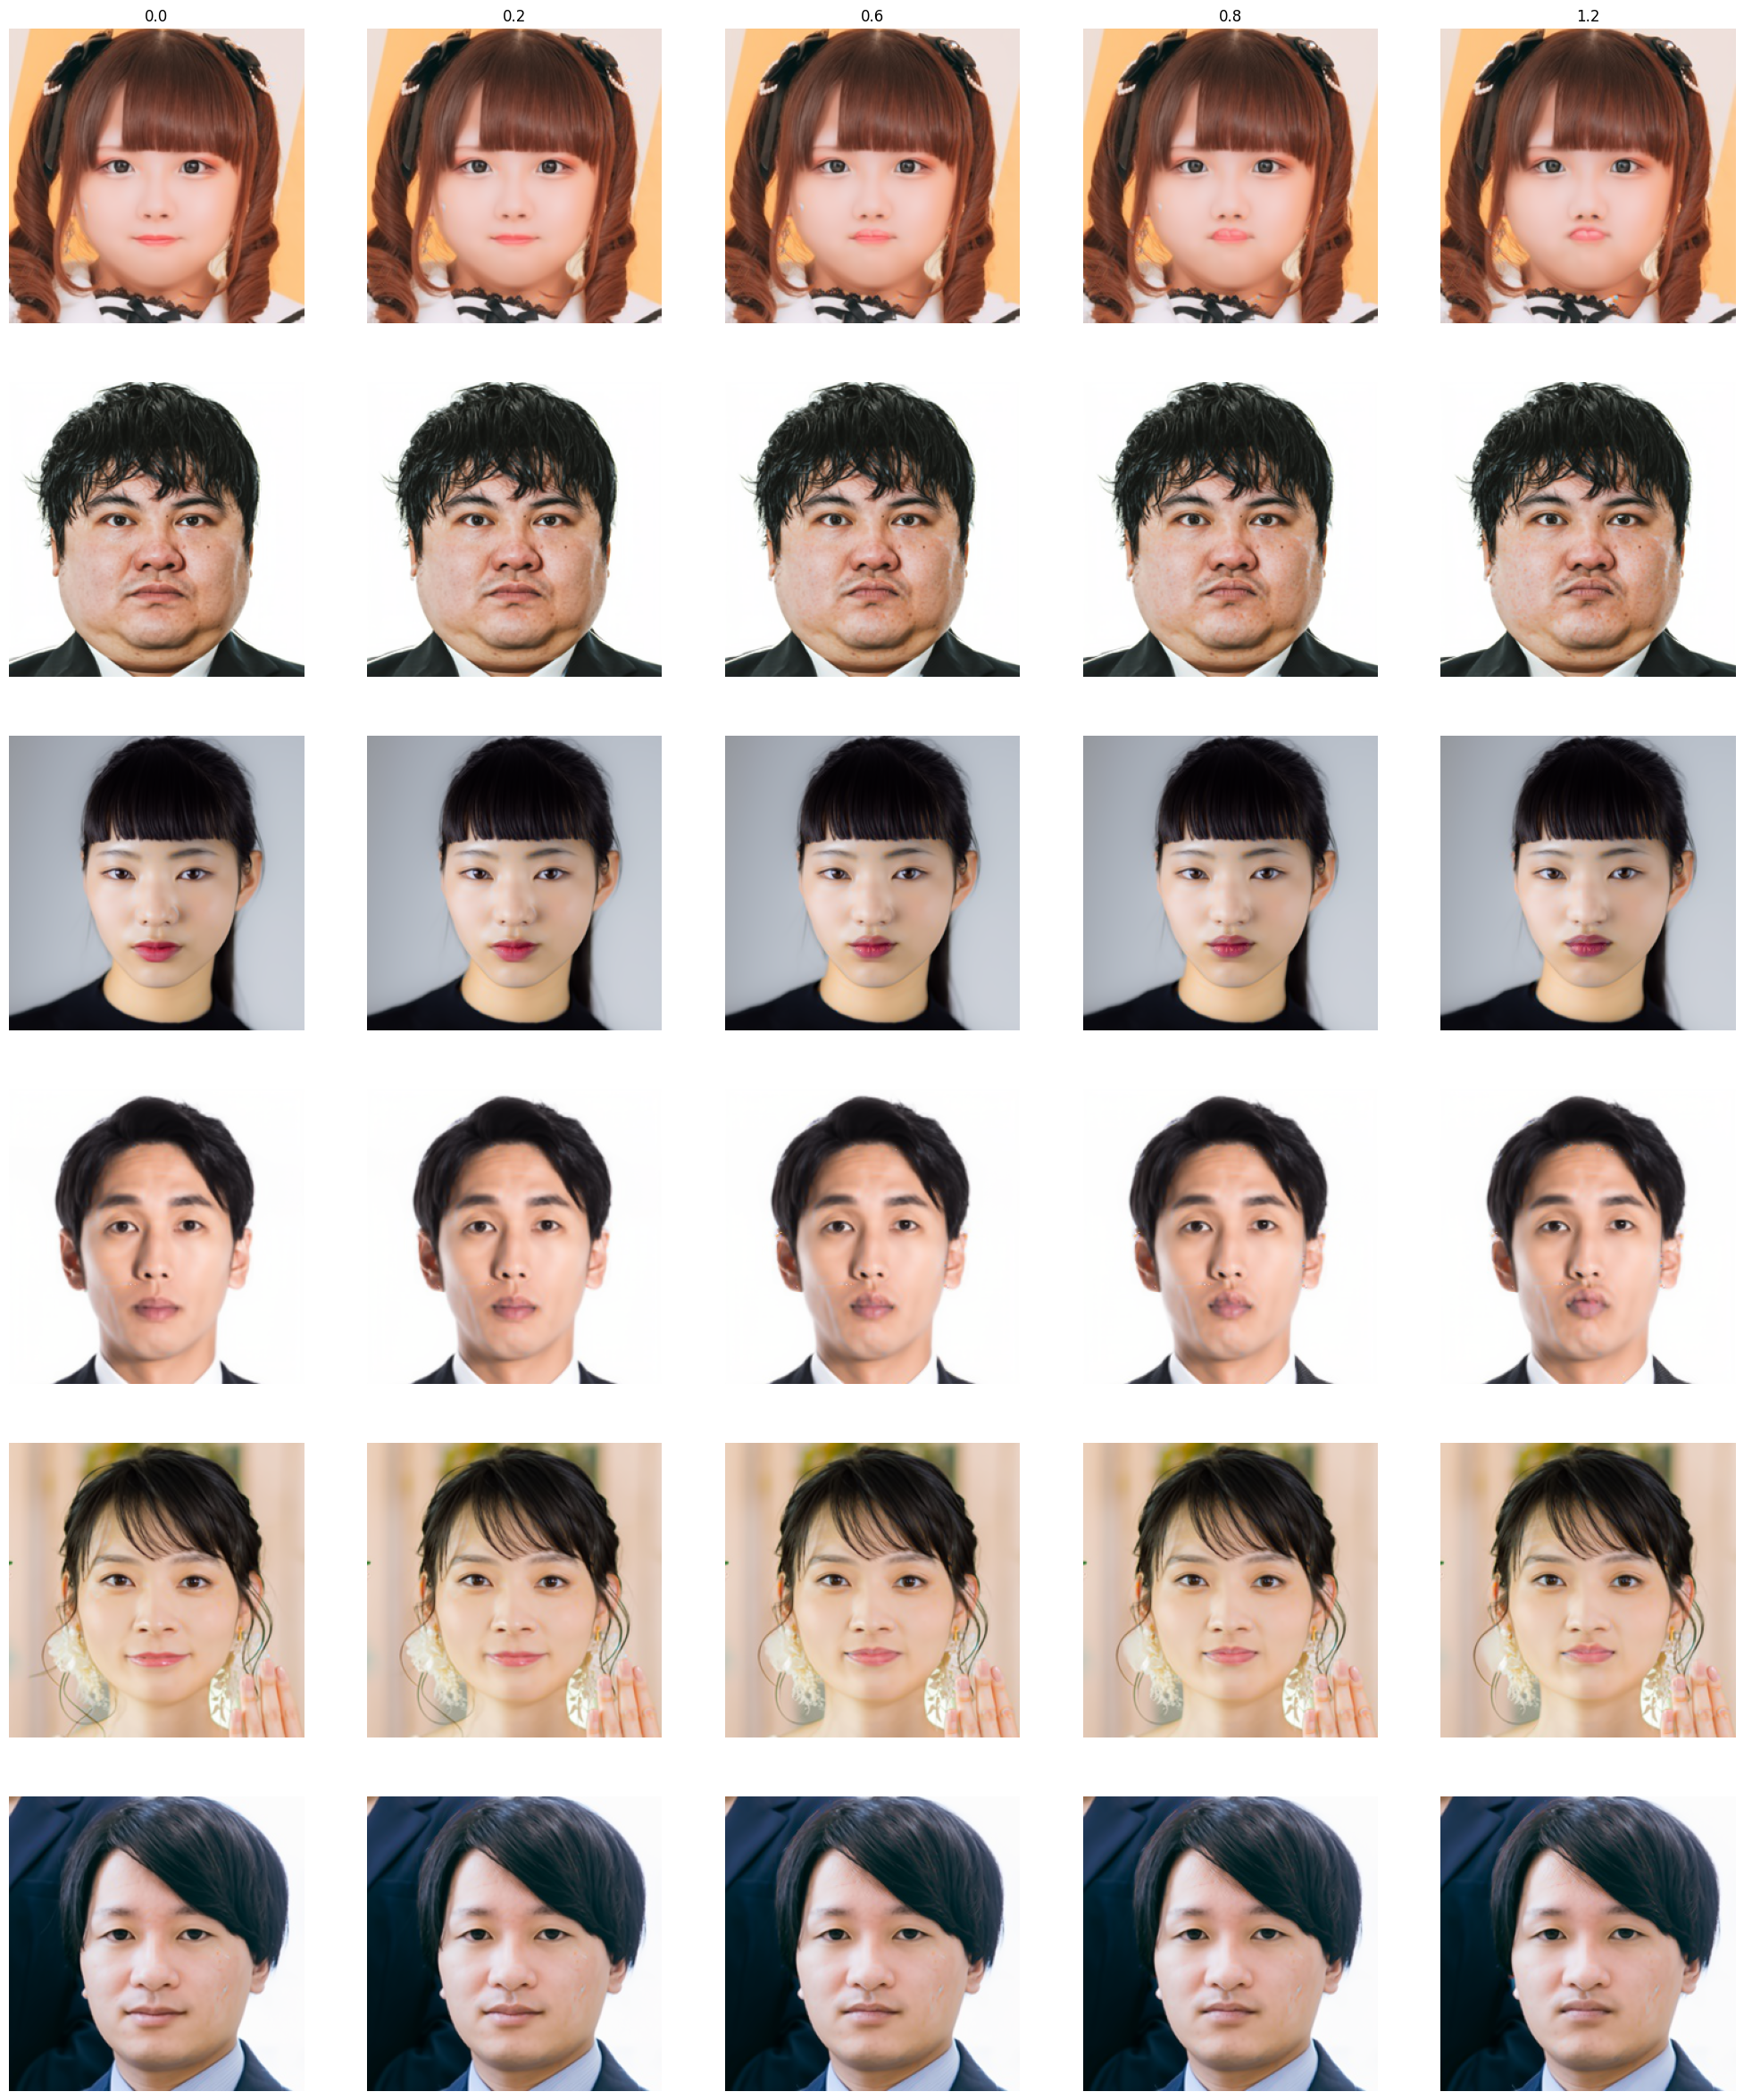

In [206]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(num_to, num_show, figsize=(5*num_show, 5*num_to))
for i,pred in enumerate(preds_face):
    for j,k in enumerate(np.linspace(0,len(pred)-1,num_show,dtype=np.uint8)):
        ax[i,j].imshow(pred[k].permute(1,2,0).cpu())
        if i == 0:
            ax[i,j].set_title(np.array(alpha[k].cpu()))
        ax[i,j].axis('off')

In [207]:
from PIL import Image

preds_all_pil = []
for pred in preds_all:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_all_pil.append(pred_pil)

## gifの保存

### Pose

In [208]:
dst_dir = "imgs_test/imgs_parts_transfer/pose/"
for i,pred_pil in enumerate(preds_pose_pil):
    frs_dir = f"{dst_dir}{names_batch_pose_from[0]}2{names_batch_pose_from[1]}-trans-{names_batch_to[i]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
    dst_path = frs_dir + file_name

    pred_pil[0].save(
        dst_path,
        format="gif",
        save_all=True,
        append_images=pred_pil,
        duration=120//(len(alpha)-1),
        loop=0,
    )

### Eye

In [209]:
dst_dir = "imgs_test/imgs_parts_transfer/eye/"
for i,pred_pil in enumerate(preds_eye_pil):
    frs_dir = f"{dst_dir}{names_batch_eye_from[0]}2{names_batch_eye_from[1]}-trans-{names_batch_to[i]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
    dst_path = frs_dir + file_name

    pred_pil[0].save(
        dst_path,
        format="gif",
        save_all=True,
        append_images=pred_pil,
        duration=120//(len(alpha)-1),
        loop=0,
    )

### Mouth

In [210]:
dst_dir = "imgs_test/imgs_parts_transfer/mouth/"
for i,pred_pil in enumerate(preds_mouth_pil):
    frs_dir = f"{dst_dir}{names_batch_mouth_from[0]}2{names_batch_mouth_from[1]}-trans-{names_batch_to[i]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
    dst_path = frs_dir + file_name

    pred_pil[0].save(
        dst_path,
        format="gif",
        save_all=True,
        append_images=pred_pil,
        duration=120//(len(alpha)-1),
        loop=0,
    )

### Face

In [211]:
dst_dir = "imgs_test/imgs_parts_transfer/face/"
for i,pred_pil in enumerate(preds_face_pil):
    frs_dir = f"{dst_dir}{names_batch_mouth_from[0]}2{names_batch_mouth_from[1]}-trans-{names_batch_to[i]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
    dst_path = frs_dir + file_name

    pred_pil[0].save(
        dst_path,
        format="gif",
        save_all=True,
        append_images=pred_pil,
        duration=120//(len(alpha)-1),
        loop=0,
    )

### All

In [212]:
dst_dir = "imgs_test/imgs_parts_transfer/all/"
for i,pred_pil in enumerate(preds_all_pil):
    frs_dir = f"{dst_dir}{names_batch_mouth_from[0]}2{names_batch_mouth_from[1]}-trans-{names_batch_to[i]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
    dst_path = frs_dir + file_name

    pred_pil[0].save(
        dst_path,
        format="gif",
        save_all=True,
        append_images=pred_pil,
        duration=120//(len(alpha)-1),
        loop=0,
    )

## 静止画像（フレーム）の保存

### Pose

In [213]:
from torchvision.utils import save_image

dst_dir = "imgs_test/imgs_parts_transfer/pose/"
for i,pred in enumerate(preds_pose):
    frs_dir = f"{dst_dir}{names_batch_pose_from[0]}2{names_batch_pose_from[1]}-trans-{names_batch_to[i]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    for j,p in enumerate(pred):
        file_name = f"{frs_dir}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
        save_image(p, file_name, format='PNG')

### Eye

In [214]:
from torchvision.utils import save_image

dst_dir = "imgs_test/imgs_parts_transfer/eye/"
for i,pred in enumerate(preds_eye):
    frs_dir = f"{dst_dir}{names_batch_eye_from[0]}2{names_batch_eye_from[1]}-trans-{names_batch_to[i]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    for j,p in enumerate(pred):
        file_name = f"{frs_dir}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
        save_image(p, file_name, format='PNG')

### Mouth

In [215]:
from torchvision.utils import save_image

dst_dir = "imgs_test/imgs_parts_transfer/mouth/"
for i,pred in enumerate(preds_mouth):
    frs_dir = f"{dst_dir}{names_batch_mouth_from[0]}2{names_batch_mouth_from[1]}-trans-{names_batch_to[i]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    for j,p in enumerate(pred):
        file_name = f"{frs_dir}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
        save_image(p, file_name, format='PNG')

### Face

In [216]:
from torchvision.utils import save_image

dst_dir = "imgs_test/imgs_parts_transfer/face/"
for i,pred in enumerate(preds_face):
    frs_dir = f"{dst_dir}{names_batch_mouth_from[0]}2{names_batch_mouth_from[1]}-trans-{names_batch_to[i]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    for j,p in enumerate(pred):
        file_name = f"{frs_dir}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
        save_image(p, file_name, format='PNG')

### All

In [217]:
from torchvision.utils import save_image

dst_dir = "imgs_test/imgs_parts_transfer/all/"
for i,pred in enumerate(preds_all):
    frs_dir = f"{dst_dir}{names_batch_mouth_from[0]}2{names_batch_mouth_from[1]}-trans-{names_batch_to[i]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    for j,p in enumerate(pred):
        file_name = f"{frs_dir}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
        save_image(p, file_name, format='PNG')

In [251]:
print('index: name')
for i, name in enumerate(names_batch_to):
    print(f'{i:5}: {name}')

index: name
    0: azuki_default
    1: danda_default
    2: nanko_default
    3: ookawa_default
    4: takebe_default
    5: woman_default


In [242]:
print('index: amplitude')
for i,a in enumerate(np.array(alpha.detach().cpu())):
    print(f'{i:5}: {a}')

index: amplitude
    0: 0.0
    1: 0.4285714328289032
    2: 0.8571428656578064
    3: 1.2857142686843872
    4: 1.7142857313156128
    5: 2.142857074737549
    6: 2.5714285373687744
    7: 3.0
    8: 3.4285714626312256
    9: 3.857142925262451
   10: 4.285714149475098
   11: 4.714285850524902
   12: 5.142857074737549
   13: 5.5714287757873535
   14: 6.0


In [ ]:
index_name = 0
index_amp = 0
dst_dir = "imgs_test/imgs_transfer/"
file_name = "yotaka2smile-trans-women.png"
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
dst_path = dst_dir + file_name
save_image(preds[index_name][index_amp], dst_path)